#  Influence of Acidic Properties on Red Wine Quality

## Introduction

Understanding the chemical properties that contribute to red wine quality has been an area of focus for years. For example, density, sulphate concentration, and alcohol content can vary between wines that relate to overall quality (1). Specifically, acids in wine contribute to sourness, astringency, and colour (2). Here, we ask if we can use wine acidity measurements to predict whether a wine is of good or bad quality.

[Our dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) originally includes 11 chemical properties for various Portuguese red wines, with the outcome variable being a categorical quality rating from 0 to 10 given by expert wine tasters. The data set contains several acidity measurements: fixed acidity, volatile acidity, citric acid, and pH, and our group became interested in seeing if these acidic properties can predict quality ratings. Wine acidity is often classified as either fixed or volatile, which relates to the acid’s ability to be removed by steam distillation (2). While volatile acids can be readily removed by distillation, fixed acids cannot. Therefore, for the purposes of this analysis, we have selected fixed and volatile acidity as our two predictor variables to perform K-nearest neighbors classification to predict the quality of wines.  

## Exploratory Data Analysis

In [18]:
# First we loaded the tidyverse, repr, tidymodels, and plyr packages
library(tidyverse)
library(repr)
library(tidymodels)
library(plyr)

We loaded the csv file for red wine data from the UCI website (Table 1).

In [19]:
wine_data <- read_delim('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delim = ";")
colnames(wine_data) <- make.names(colnames(wine_data)) # We replaced spaces in column titles with periods.
head(wine_data) 

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


*Table 1: Imported red wine dataset. 6 rows from full dataset are shown for demonstrative purposes.* 

Then, we selected the predictor and target variables needed for analysis. As this is a classification problem, we converted quality from a numeric scale (0 to 10) to a binary factor (“bad” (from 0 to 5) and “good” (from 6 to 10)) to obtain two classes (Table 2).

In [20]:
wine_data_wrangled <- wine_data %>% 
    select(fixed.acidity, volatile.acidity, quality) %>% 
    mutate(quality = revalue(as_factor(quality > 5), c('FALSE' = 'bad', 'TRUE' = 'good'))) 
    
head(wine_data_wrangled)

fixed.acidity,volatile.acidity,quality
<dbl>,<dbl>,<fct>
7.4,0.70,bad
7.8,0.88,bad
7.8,0.76,bad
11.2,0.28,good
7.4,0.70,bad
7.4,0.66,bad


*Table 2: Wrangled red wine dataset. 6 rows from full dataset are shown for demonstrative purposes.*

Next, we split the data into training and testing sets, with 75% of data into the training set, and 25% into the testing set.

In [21]:
set.seed(1)
wine_split <- initial_split(wine_data_wrangled, prop = 0.75, strata = quality) # We split 75% of data into the training set, and 25% into the testing set.
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

The following cell contains a **data summary table** of the training set (Table 3). It contains means of both predictors for each *quality* class, which could help predict relationships between acidity and quality. We also report the number of observations in each class. Here we also show that there are no missing observations from our dataset in the column *num.missings.obs*.

In [22]:
# Note: only training set data is included in the data summary table.
wine_data_summarized <- wine_train %>% 
    group_by(quality) %>% 
    dplyr::summarise(mean.fixed.acidity = mean(fixed.acidity), 
                     mean.volatile.acidity = mean(volatile.acidity),                      
                     num.obs = n(),
                     num.missing.obs = sum(is.na(wine_train)))
wine_data_summarized

`summarise()` ungrouping output (override with `.groups` argument)



quality,mean.fixed.acidity,mean.volatile.acidity,num.obs,num.missing.obs
<fct>,<dbl>,<dbl>,<int>,<int>
bad,8.103943,0.5932975,558,0
good,8.484735,0.4730919,642,0


*Table 3: Data summary table of training dataset.*

The next 2 cells contain **histograms** comparing distributions of both predictors for both *quality* types (Figure 1 and 2). These were performed to see if the distribution for each of these variables varied greatly between good and bad quality wines. If the distributions were quite distinct, we might expect our classification algorithm to perform more accurately than if they were quite similar and overlapping. We observed overall no major differences in the distributions for each variable between each class. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



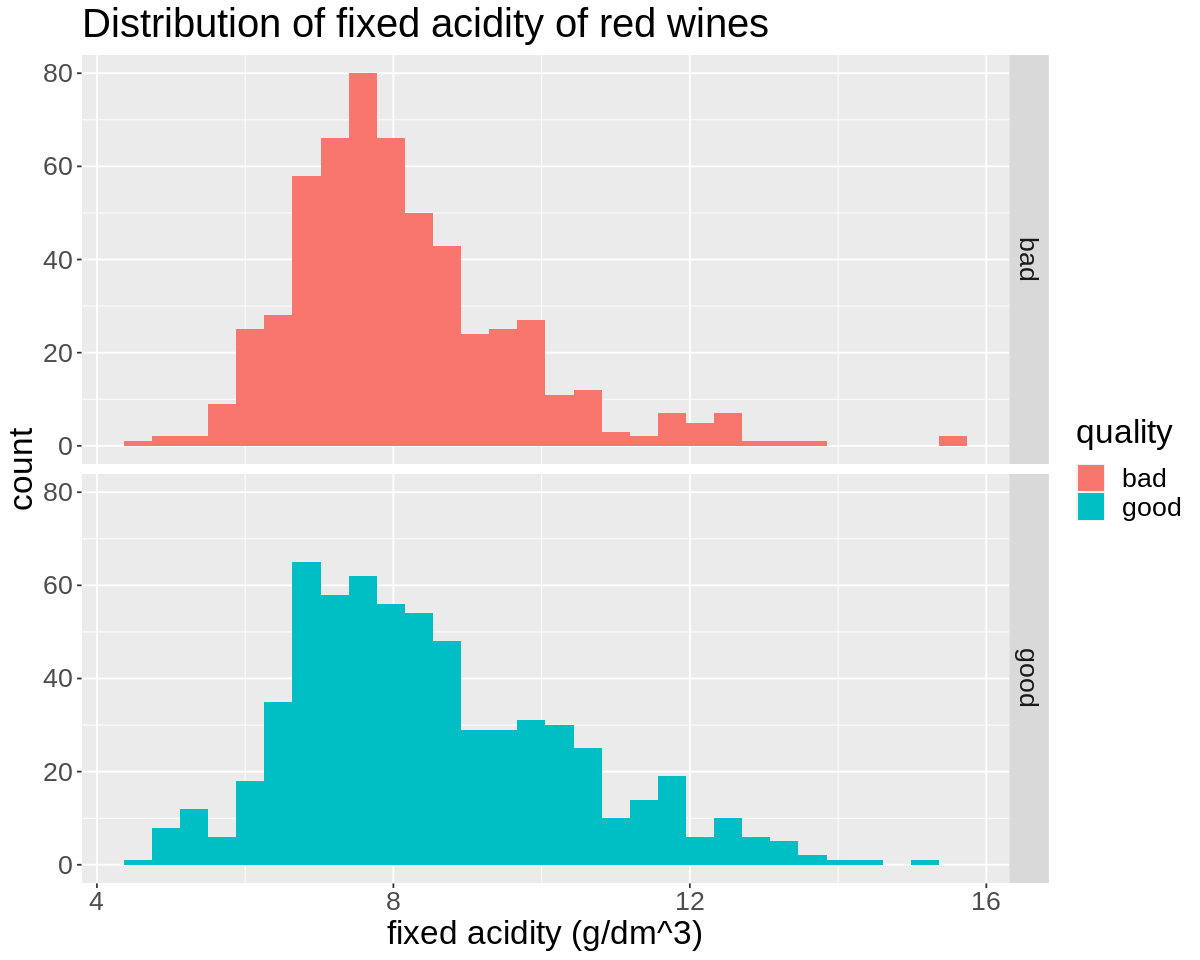

In [23]:
# Note: we used only training set data to create all of our histograms
options(repr.plot.width = 10, repr.plot.height = 8)
fixed_acidity_graph <- wine_train %>% 
    ggplot(aes(x = fixed.acidity, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('fixed acidity (g/dm^3)') + 
        ggtitle('Distribution of fixed acidity of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
fixed_acidity_graph

*Figure 1: Distribution of fixed acidity of good and bad quality red wines.*

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



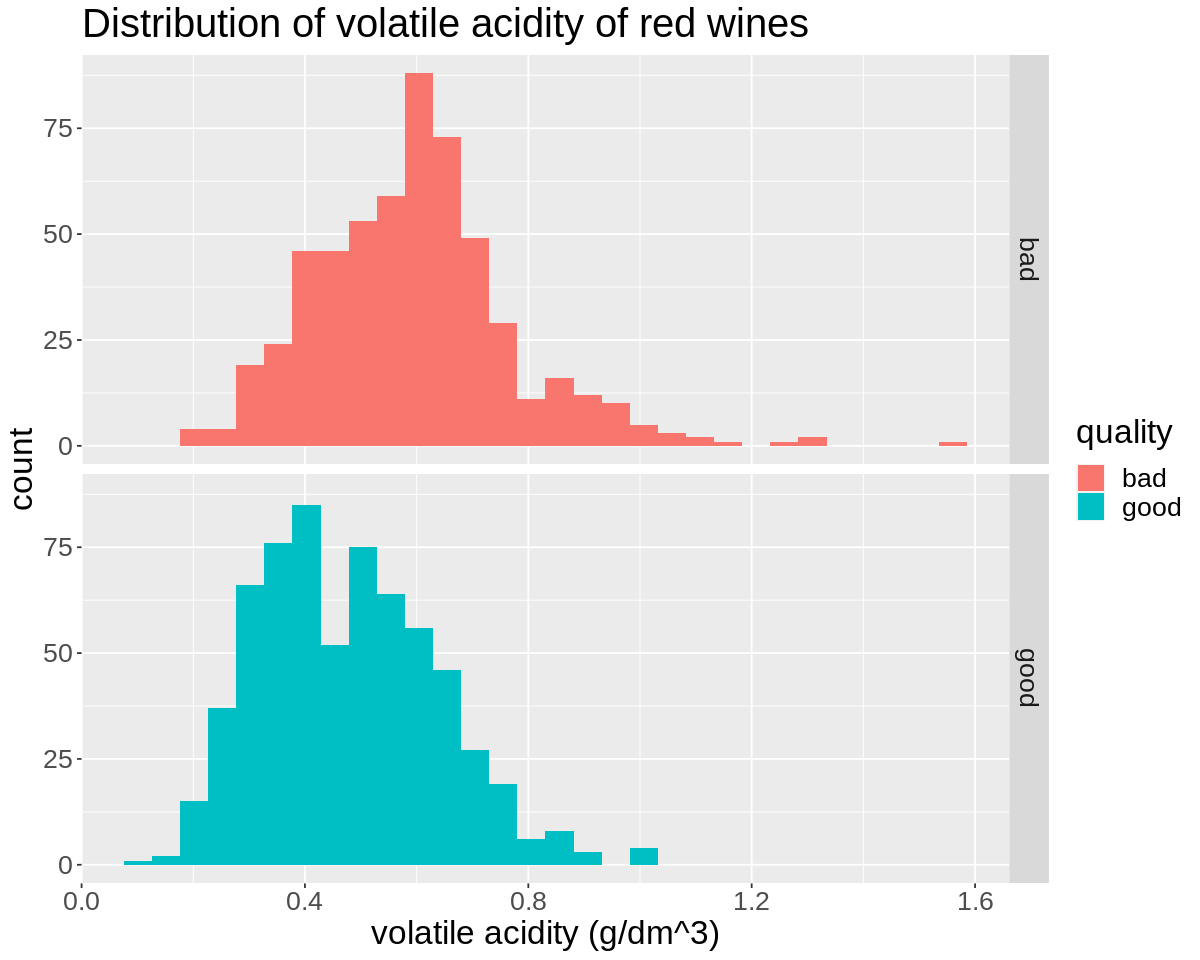

In [24]:
volatile_acidity_graph <- wine_train %>% 
    ggplot(aes(x = volatile.acidity, fill = quality)) +
        geom_histogram(position = 'identity') +
        xlab('volatile acidity (g/dm^3)') + 
        ggtitle('Distribution of volatile acidity of red wines') +
        facet_grid(quality ~ .) +
        theme(text = element_text(size = 20))
volatile_acidity_graph

*Figure 2: Distribution of volatile acidity of good and bad quality red wines.*

We then created a **scatterplot** using the training set with fixed and volatile acidity on the x- and y-axes respectively. Points are coloured according to their known quality labels. This visualization was created to understand the trend in our data, which allowed us to estimate the potential accuracy of our classification model. While we do see a large degree of mixing among the classes, it appears that good quality wines dominate the region of the graph characterized by low volatile acidity, while bad wines tend to have higher volatile acidity.

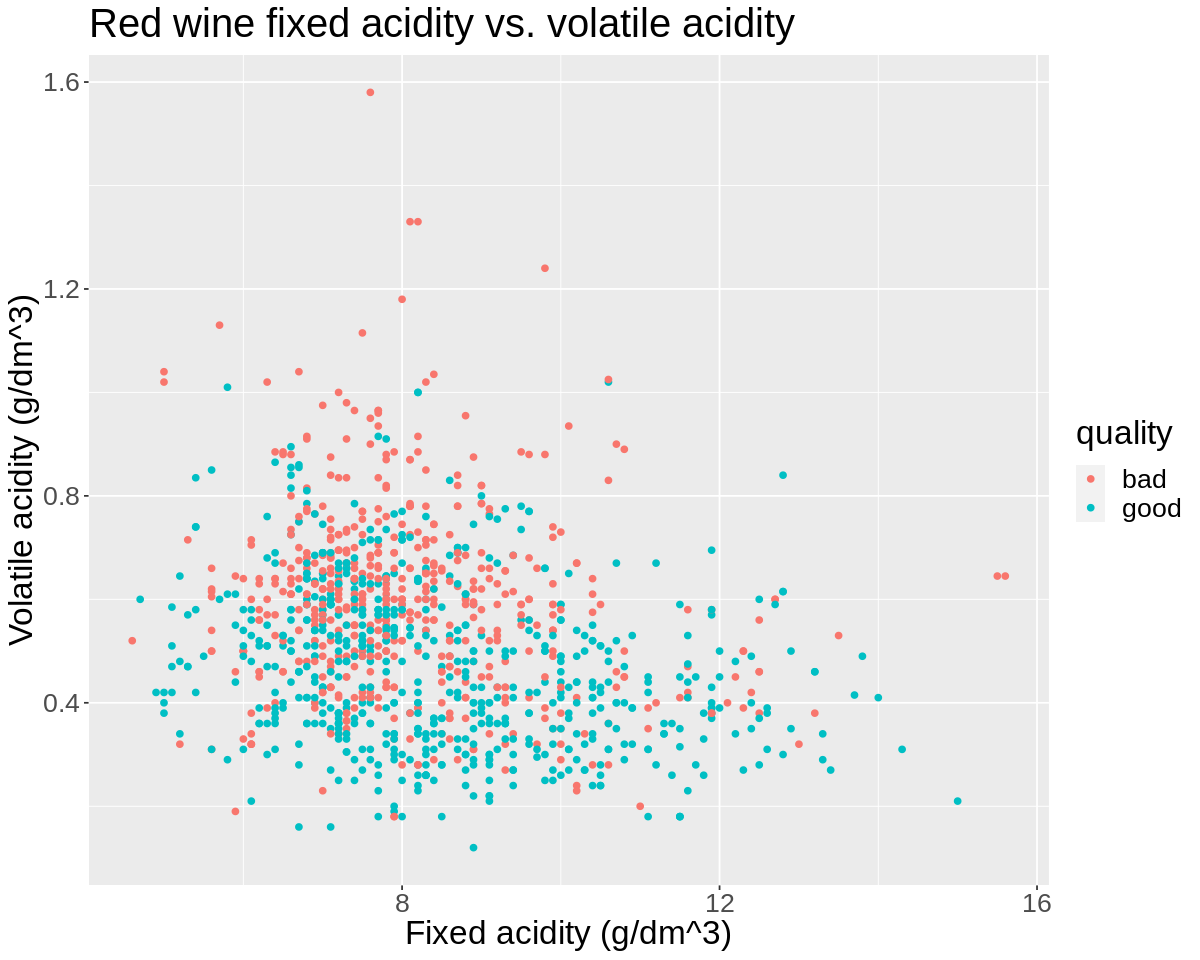

In [25]:
fixed_vs_volatile_plot <- wine_train %>% 
     ggplot(aes(x = fixed.acidity, y = volatile.acidity, colour = quality)) +
         geom_point() +
         labs(x = 'Fixed acidity (g/dm^3)', y = 'Volatile acidity (g/dm^3)') +
         ggtitle('Red wine fixed acidity vs. volatile acidity') +
         theme(text = element_text(size = 20))
fixed_vs_volatile_plot

*Figure 3: Red wine fixed acidity vs. volatile acidity by quality.*

## Methods & Results

Prior to classification, we first identify the optimal number of neighbours to use for the K-nearest neighbors algorithm. We use 5-fold cross validation to assess the accuracy of k ranging from 1 to 20. Table 4 outlines the accuracy for the first 3 values of k.

In [26]:
set.seed(1)

wine_recipe <- recipe(quality ~ ., wine_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

wine_vfold <- vfold_cv(wine_train, fold = 5, strata = quality)

wine_workflow <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

wine_results <- wine_workflow %>%
    tune_grid(resamples = wine_vfold, grid = gridvals) %>%
    collect_metrics
head(wine_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6757972,10,0.017220626,Model01
1,roc_auc,binary,0.6744301,10,0.016622133,Model01
2,accuracy,binary,0.6757762,10,0.016115072,Model02
2,roc_auc,binary,0.6829701,10,0.008281837,Model02
3,accuracy,binary,0.6657547,10,0.011630777,Model03
3,roc_auc,binary,0.7019761,10,0.007791262,Model03


*Table 4: Accuracy summary table for 5-fold cross validation. K-values of 1-3 are only shown above.*

The accuracy estimates for each neighbour are extracted from the results and plotted on an Accuracy Estimate versus Neighbours plot below (Figure 4).

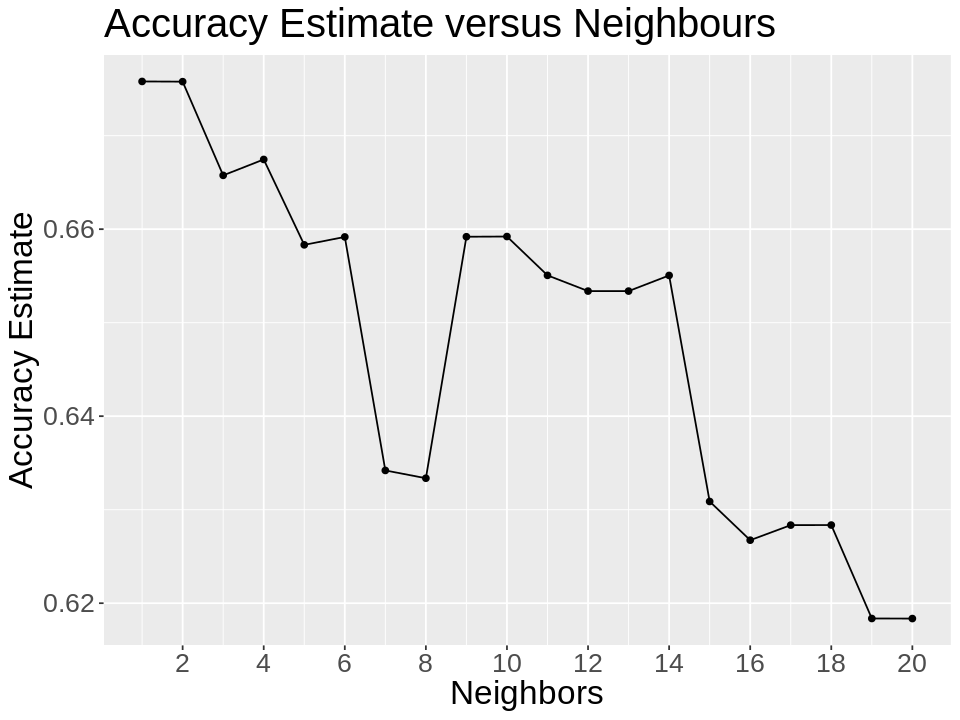

In [27]:
accuracies <- wine_results %>%
    filter(.metric == "accuracy")

options(repr.plot.width = 8, repr.plot.height = 6)
accuracy_vs_k <- accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate versus Neighbours") +
    theme(text=element_text(size=20)) +
    scale_x_continuous(breaks = seq(0, 20, by = 2))
accuracy_vs_k

*Figure 4: Accuracy estimate vs. neighbors, ranging from 1-20.*

Given this plot, we decided to train our algorithm using k = 5. Choosing a small k-value may result in the model overfitting the data, so we chose to not consider k-values under 3. Although k = 4 and k = 6 yields slightly greater accuracy than k = 5, selecting an odd k-value allows the model to avoid instances of ties among classes of neighboring points. Additionally, k-values larger than 6 do not appear to be significantly more accurate, and selecting a large k-value risks an underfit model. Therefore, choosing 5 neighbors appears to balance the issues of overfitting and underfitting, while still maintaining accuracy. 

Table 5 shows the accuracy of our model after classifying the testing set. We see a 61.65% accuracy for our model in predicting the classes of the testing set.

In [28]:
wine_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

wine_fit <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_final_spec) %>% 
    fit(data = wine_train)

wine_predictions <- predict(wine_fit, wine_test) %>% 
    bind_cols(wine_test)

wine_prediction_accuracy <- wine_predictions %>% 
    metrics(truth = quality, estimate = .pred_class)

wine_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6165414
kap,binary,0.2298172


*Table 5: Accuracy of K-nearest neighbors classification model on testing set.*

To visualize the accuracy of our model, we combined two scatter plots where the fixed and volatile acidity are on the x and y axis, respectively, and colored by quality using the colours pink and blue. The points in this visualization represent the observations in the full dataset and their true classes. The second scatterplot creates the background colour of the graph, which indicates the decision of the model (Figure 5).

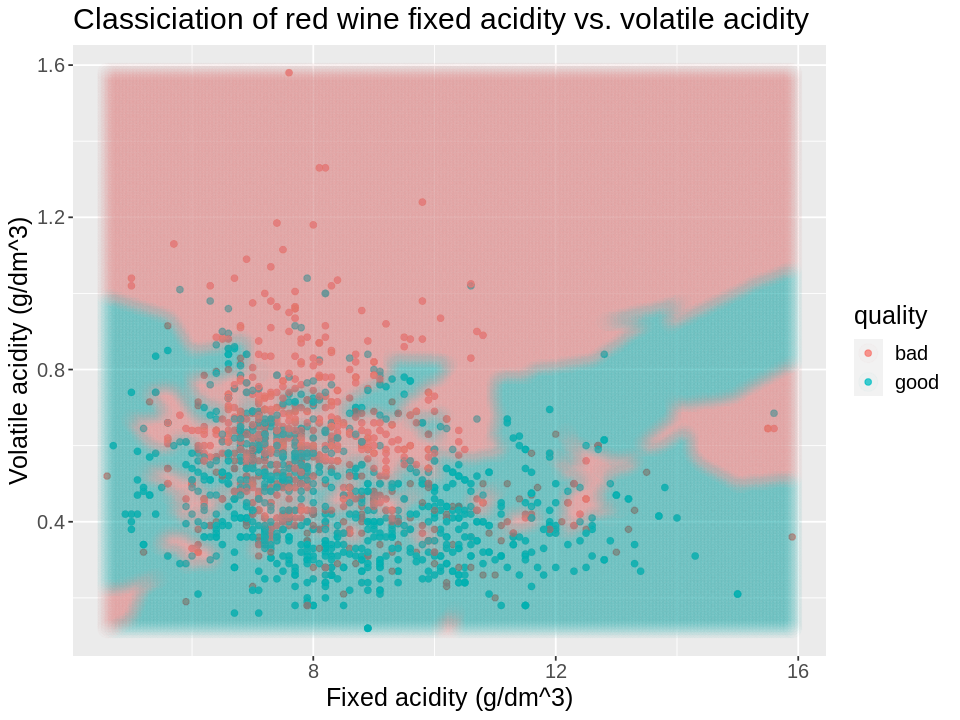

In [29]:
# create the grid of fixed acidity/volatile acidity vals, and arrange in a data frame
are_grid <- seq(min(wine_data_wrangled$fixed.acidity), max(wine_data_wrangled$fixed.acidity), length.out = 200)
smo_grid <- seq(min(wine_data_wrangled$volatile.acidity), max(wine_data_wrangled$volatile.acidity), length.out = 200)
asgrid <- as_tibble(expand.grid(fixed.acidity = are_grid, volatile.acidity = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(wine_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
    select(.pred_class, fixed.acidity, volatile.acidity)


# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
wine_plot <- ggplot() +
    geom_point(data = wine_data_wrangled, mapping = aes(x = fixed.acidity, y = volatile.acidity, color = quality), alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = fixed.acidity, y = volatile.acidity, color = .pred_class), alpha = 0.02, size = 5.) +
    labs(x = 'Fixed acidity (g/dm^3)', y = 'Volatile acidity (g/dm^3)') +
    ggtitle('Classiciation of red wine fixed acidity vs. volatile acidity') +
    theme(text = element_text(size = 15))

wine_plot

*Figure 5: Classification of quality of red wine for fixed and volatile acidity as predictors.*

## Discussion

In this analysis, we attempted to classify subjective red wine *quality* (“good” or “bad”) using two variables related to acidity: *fixed* and *volatile* acidity. We expected these acidic properties to relate to subjective taste, although the direction of this prediction was unknown. We generated a model that yielded 61.65% accuracy in predicting wine quality.  


Although the accuracy of our model was not very high, there are still some broad conclusions that can be made. Vertically, the classifier is separated into approximately four regions: a top quarter corresponding to bad quality wines, a quarter of mostly bad quality wines, a quarter of a mix of good and bad quality wines, and a bottom quarter of good quality wines. For our analysis, these regions will be referred to as Region 1, 2, 3, and 4, respectively. It seems that in Regions 1 and 4, fixed acidity does not contribute much compared to classification as regardless of the fixed acidity measurement, it is classified as good or bad. Hence, we can conclude that good quality wines tend to have a lower volatile acidity in the range of 0 - 0.4 g/dm$^3$ whereas bad quality wines tend to have a volatile acidity greater than 0.8 g/dm$^3$. 

Since acidity plays a role in red wine taste, we anticipated that our classifier would be able to classify red wines based on these acidity measurements. Our classifier shows that we were able to achieve 61.65% accuracy. The low classifier prediction accuracy suggests that acidity is not the only factor affecting quality. A more comprehensive set of predictors could include measurements of other chemical components of red wine such as sugars, tannins, and ethanol (2). Trace components such as sugars, tannins, and ethanol make up approximately 1%, 0.4%, and 14% of red wine, respectively (2$. Acids on average make up 0.5% of the chemical composition of wines$^2$. Additionally, we simplified our analysis to predict a binary classification of quality (“good” or “bad”). This dataset originally quantifies quality on a scale from 0-10, and it would be interesting in future analyses to predict quality according to this or a similar measure.

Our results have important implications. In predicting which wines will perform the best in market sales or competitions, understanding the relationship between acidity and quality would be useful. Wine makers and sommeliers can use this knowledge to guide wine making practices. Additionally, while taste itself is quite subjective, our results suggest that the chemical properties of wine have some degree of effects on rated quality. It would be interesting to investigate what factors beyond chemical properties contribute to taste ratings, such as individual differences among wine tasters. Our analysis can inform other questions such as: Do certain countries have a preference for a certain acidity of wine? Is there an ideal ratio between acidic compounds and other flavour compounds? Can this analysis also be done with white wines, and if not, what other chemical properties are most relevant to subjective taste in these wines? In conclusion, our K-nearest neighbors classification model demonstrated a potential relationship between fixed and volatile acidity in red wines and subjective quality, although there remains more investigation to be done and further questions to be addressed.

## References

$^1$Cortez, Paulo, et al. "Modeling Wine Preferences by Data Mining from Physicochemical Properties." Decision Support Systems, vol. 47, no. 4, 2009, pp. 547-553.

$^2$Jackson, Ronald S. “6 - Chemical Constituents of Grapes and Wine”. Elsevier Inc, 2014.

$^3$Jackson, Ronald S. “Chapter 6 - Qualitative Wine Assessment”. Elsevier Ltd, 2017.
